In [1]:
# do not show warnings 
import warnings
warnings.filterwarnings('ignore')

In [50]:
import os

import json
import pickle
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

In [33]:
PATH_DATA = "yelp_dataset/yelp_academic_dataset_review.json"

NB_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
VAL_SPLIT = 0.2

VOC_SIZE = 10000
MIN_WORDS = 20
MAX_WORDS = 100

In [5]:
def load_data(path):
    """ Load the json file and return it as a dataframe"""
    reviews = []
    for line in open(path, 'r'):
        reviews.append(json.loads(line))

    reviews = pd.DataFrame(reviews)
    return reviews

In [12]:
print("Loading data...")
# load the data
reviews = load_data(PATH_DATA)

X = reviews.text
y = reviews.stars
print("The dataset has ", len(X), "samples")

Loading data...
The dataset has  5996996 samples


In [13]:
# Take only the first 500 000 samples, so the training time will be lower
X = X[:500000]
y= y[:500000]

In [16]:
def plot_labels(y):
    """ Plot the distribution of the labels """
    plt.figure(figsize=(8,5))
    y.hist()
    plt.title('label distribution')
    plt.ylabel('nb samples')
    plt.xlabel('labels')
    plt.show()

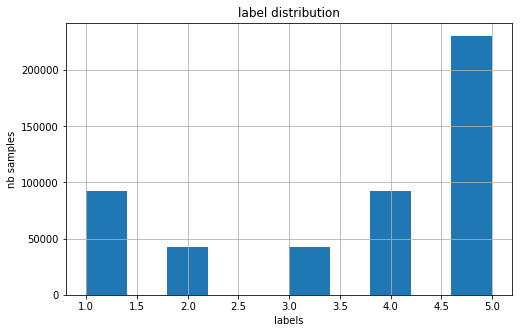

In [17]:
# plot the label distribution
plot_labels(y)

In [20]:
def text_to_seq(X, max_lenght):
    """ Convert text to padded sequence with max lenght"""
    sequences = tokenizer.texts_to_sequences(X)
    sequences = sequence.pad_sequences(sequences, maxlen=max_lenght)
    return sequences

def save_object(obj, filename):
    """ Save the obj in a pickle file"""
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [22]:
# tokenize the data
tokenizer = Tokenizer(num_words=VOC_SIZE)
tokenizer.fit_on_texts(X)

X = text_to_seq(X, MAX_WORDS)
save_object(tokenizer, 'tokenizer_Yelp_keras_stars_New.pkl')

## Model

In [39]:
# split the data in train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [38]:
def y_to_categorical(y):
    """ Converts y to a categorical variable """
    num_classes = np.max(y) + 1
    y = to_categorical(y, num_classes)
    y = np.array(y)
    
    return y

In [40]:
# convert y to categorical attribute
y_train = y_to_categorical(y_train)
print("Y shape: ", y_train.shape)

Y shape:  (400000, 6)


In [32]:
model = Sequential()
model.add(Embedding(VOC_SIZE, 128, input_length=MAX_WORDS))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 1,379,590
Trainable params: 1,379,590
Non-trainable params: 0
_________________________________________________________________


In [34]:
# train the model
opt = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])

keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NB_EPOCHS,
                    validation_split=VAL_SPLIT)

Train on 320000 samples, validate on 80000 samples
Epoch 1/15
320000/320000 [==============================] - 758s 2ms/step - loss: 1.4493 - acc: 0.4508 - val_loss: 1.2791 - val_acc: 0.4627
Epoch 2/15
320000/320000 [==============================] - 777s 2ms/step - loss: 1.1412 - acc: 0.5066 - val_loss: 1.0066 - val_acc: 0.6199
Epoch 3/15
320000/320000 [==============================] - 789s 2ms/step - loss: 0.9903 - acc: 0.6124 - val_loss: 0.9110 - val_acc: 0.6221
Epoch 4/15
320000/320000 [==============================] - 780s 2ms/step - loss: 0.9183 - acc: 0.6230 - val_loss: 0.8629 - val_acc: 0.6275
Epoch 5/15
320000/320000 [==============================] - 702s 2ms/step - loss: 0.8770 - acc: 0.6283 - val_loss: 0.8361 - val_acc: 0.6331
Epoch 6/15
320000/320000 [==============================] - 699s 2ms/step - loss: 0.8512 - acc: 0.6334 - val_loss: 0.8165 - val_acc: 0.6384
Epoch 7/15
320000/320000 [==============================] - 702s 2ms/step - loss: 0.8330 - acc: 0.6390 - val_

In [35]:
# save the model
model.save("Yelp_class6.h5")

## Results

In [36]:
def plot_accuracy(history):
    """ Plot the accurary vs epoch for the train and validation set"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
def plot_loss(history):
    """ Plot the loss vs epoch for the train and validation set"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

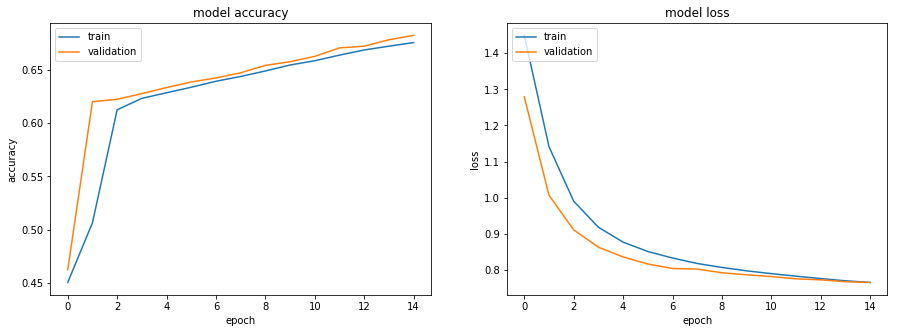

In [37]:
# plot the loss and the accuracy
plt.figure(figsize=(15,5))

gs = gridspec.GridSpec(1,2)

ax = plt.subplot(gs[0])
plot_accuracy(history)

ax = plt.subplot(gs[1])
plot_loss(history)

In [ ]:
print("Predict test labels...\n")
y_pred = model.predict_classes(x_test)
print("Results\n")
print(metrics.classification_report(y_test,y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred))

Predict test labels...

